In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
# Get columns and data types for station table
inspector = inspect(engine)
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
# Get columns and data types for measurement table
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23',)

The most recent date is 2017-08-23.
The date one year from the last date in the data set is 2016-08-23.


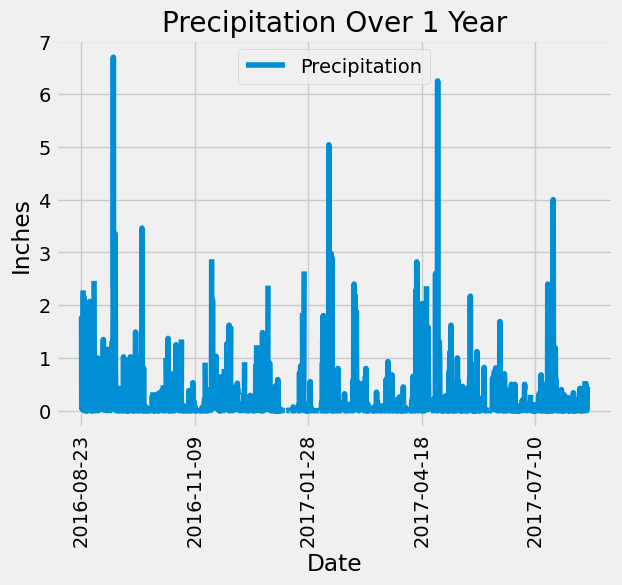

In [30]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first().date
print(f'The most recent date is {recent_date}.')

# Calculate the date one year from the last date in data set.
one_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(f'The date one year from the last date in the data set is {one_year}.')

# Perform a query to retrieve the data and precipitation scores
precip_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(precip_data,columns=['Date','Precipitation']).set_index('Date')

# Sort the dataframe by date
precip_sorted = precip_df.sort_values('Date')

# Use Pandas Plotting with Matplotlib to plot the data
precip_sorted.plot(y='Precipitation',use_index=True,title='Precipitation Over 1 Year',ylabel='Inches',xlabel='Date',rot=90)
plt.show()

In [32]:
# Use Pandas to calculate the summary statistics for the precipitation data
sum_stats = precip_sorted.describe()
sum_stats

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [33]:
# Design a query to calculate the total number stations in the dataset
total_stations = session.query(Measurement.station).group_by(Measurement.station).count()
print(f'There are a total of {total_stations} stations.')

There are a total of 9 stations.


In [34]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
activity = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc())

for row in activity:
    print(row)

# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active = activity.first()[0]
print(f'The most active station is {most_active}.')

lowest = session.query(Measurement.tobs, func.min(Measurement.tobs)).\
    filter(Measurement.station == most_active).first().tobs
print(f'The lowest temperature at the most active station is {lowest}.')

highest = session.query(Measurement.tobs, func.max(Measurement.tobs)).\
    filter(Measurement.station == most_active).first().tobs
print(f'The lowest temperature at the most active station is {highest}.')

average = session.query(Measurement.tobs, func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active).first().tobs
print(f'The lowest temperature at the most active station is {average}.')

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)
The most active station is USC00519281.
The lowest temperature at the most active station is 54.0.
The lowest temperature at the most active station is 85.0.
The lowest temperature at the most active station is 70.0.


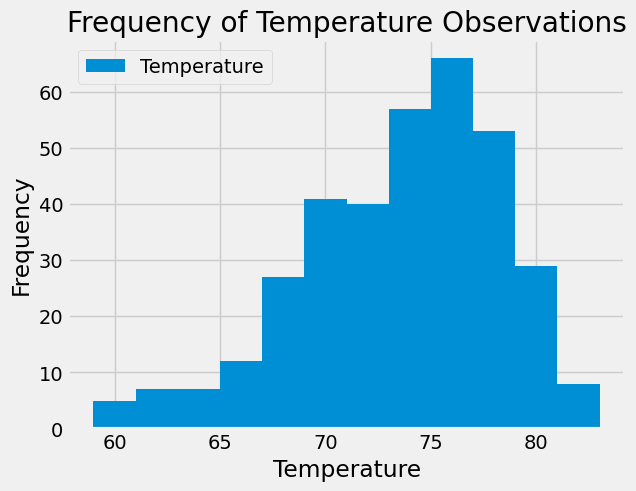

In [44]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_data = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active).\
    filter(Measurement.date >= one_year).all()

temp_df = pd.DataFrame(temp_data, columns=['Date','Temperature'])
temp_df.plot.hist(bins=12,title='Frequency of Temperature Observations')
plt.xlabel('Temperature')
plt.show()

# Close session

In [45]:
# Close Session
session.close()